In [1]:
#import stuff

%load_ext autoreload
%autoreload 2

import sys
#change path to wherever you put the code
sys.path.insert(0, '/Users/JacquelineYau/cnn/Code/ProcessingPack_Organoids/processingpack')

from copy import deepcopy
from pathlib import Path

import numpy as np
import skimage
from skimage import measure
import pandas as pd
import matplotlib.pyplot as pl

import ast
import operator

import chip
import experiment as exp
import chipcollections as collections
from org_extension import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
#define square finder
import sys
PY3 = sys.version_info[0] == 3

# Python 2/3 compatibility
if PY3:
    xrange = range

import numpy as np
from scipy import spatial as sp
import cv2 as cv
from matplotlib import pyplot as plt

def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img):
    img = cv.GaussianBlur(img, (25, 25), 0)
    squares = []
    for gray in cv.split(img):
        thrs = 130
        if thrs == 0:
            bin = cv.Canny(gray, 0, 50, apertureSize=5)
            bin = cv.dilate(bin, None)
        else:
            bin = cv.adaptiveThreshold(gray, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
        bin, contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            cnt_len = cv.arcLength(cnt, True)
            cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
            if len(cnt) == 4 and cv.contourArea(cnt) > 500 and cv.isContourConvex(cnt):
                cnt = cnt.reshape(-1, 2)
                max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in xrange(4)])
                if max_cos < 0.1:
                    squares.append(cnt)
    return squares

In [3]:
#define html table writers for summarizing data

def html_header(output_html):
    with open(output_html, "w") as out:
        header = '''
        <html>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.0/css/bootstrap.min.css">
        <link rel="stylesheet" href="https://cdn.datatables.net/1.10.19/css/jquery.dataTables.min.css">
        <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script src="https://cdn.datatables.net/1.10.19/js/jquery.dataTables.min.js"></script>
        <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.0/js/bootstrap.min.js"></script>

        <script>
        $(document).ready(function () {
        $('#microwell-data').DataTable();
        });
        </script>

        <table id="microwell-data" class="table table-striped table-bordered table-sm" cellspacing="0" width="100%">
        <thead>
        <tr>
        <th>well_id</th><th>day</th><th>median pixel intensity</th><th>hyst1 area</th><th>hyst2 area</th>
        <th>well</th><th>mw_area</th><th>hyst1</th><th>hyst2</th>
        </tr>
        </thead>
        <tbody>
        '''
        out.write(header)
        
def html_row(well,day,median,sum1,sum2,output_html):
    with open(output_html, "a") as output:
        row = '''
        <tr>
            <td>well{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_well.png alt = well{0:04d}_day{1:02d}_well.png></td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_mw_area.png alt = well{0:04d}_day{1:02d}_mw_area.png></td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_hyst1.png alt = well{0:04d}_day{1:02d}_hyst1.png></td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_hyst2.png alt = well{0:04d}_day{1:02d}_hyst2.png></td>

        </tr>
        '''.format(well,day,median,sum1,sum2)
        output.write(row)
        
        
def html_footer(output_html):
    with open(output_html, "a") as file:
        footer = '''
        </tbody></table>
        </html>
        '''
        file.write(footer)

In [5]:
#set corner positions (from stitched image, find largest rectangle of fully enclosed subgrids, see example)
# format is oc[day] = ((top left), (top right), (bottom left), (bottom right))

oc = {}

oc[0] = ((1043,3839), (12821,5267), (224,11562), (11953,12910))
oc[1] = ((1070,3771), (12846,5204), (246,11494), (11976,12844))
#oc[2] = ((979,3538), (12759,4939), (175,11256), (11900,12591))  #for gem_high
oc[2] = ((1200, 576), (21204, 684), (1104, 15600), (20976, 15336)) #For gem_low
oc[3] = ((982,3545), (12761,4949), (175,11266), (11900,12596))
oc[4] = ((975,3547), (12753,4948), (165,11269), (11895,12602))
oc[5] = ((984,3549), (12763,4950), (176,11271), (11901,12600))
oc[6] = ((978,3542), (12759,4953), (168,11269), (11901,12602))
oc[7] = ((1222,3700), (12995,5138), (397,11415), (12135,12776))
oc[8] = ((1223,3694), (12999,5134), (398,11419), (12135,12771))
oc[9] = ((240, 9081), (20148, 8937), (1290, 20292), (21060, 18972))
oc[10] = ((744, 3224), (20680, 3480), (680, 15004), (20536, 15272))  #Used as alignment, Gem_low 
oc[11] = ((248, 9100), (19448, 9227), (1464, 20091), (20360, 19048))
oc[12] = ((240, 9111), (19440, 9213), (1368, 18885), (20376, 19029))
oc[13] = ((1056, 8960), (19480, 8894), (1048, 16750), (19656, 16854))
#oc[14] = ((1368, 2500), (19696, 2508), (1488, 16456), (19656, 16452))  #For gem_high
#oc[14] =((1212, 522), (21216, 684), (1104, 15264), (20964, 15516))  #For gem_low
oc[14] = ((1200, 576), (21204, 684), (1104, 15600), (20976, 15336))
oc[15] = ((1160, 2500), (19704, 2492), (1288, 16276), (19648, 16252))
oc[16] = ((760, 2252), (19504, 2148), (816, 14628), (19584, 14556))
oc[17] = ((576, 2292), (19312, 2356), (544, 11972), (19520, 11988))
oc[18] = ((616, 296), (20624, 312), (600, 15488), (20488, 15472))
oc[19] = ((1114, 2220), (19504, 2124), (1296, 17700), (19520, 17828))
oc[20] = ((928, 2052), (19496, 2132), (920, 15820), (19512, 15868))#this is the trypan image

In [11]:
#rotate images, then save .tif and .csv files of subgrids
from datetime import datetime

subarray_dims = (5,3) #number of col,row in the fully enclosed rectangle you selected (each subgrid counts as one, so in the example image this would be 5col,3row)

#these can stay the same
tile_dims = (20, 20) 
channel = '2bf'
exposure = 10
date = datetime(2019, 5, 7)
well = 1 

timecourse_length = 1 #0 indexed Original: 21
day = 14
#for day in range(timecourse_length):
#change paths to directory containing stitched images and/or code
srcHandle = Path('/Volumes/Jacqueline_Drive/cs231n/Data/Gem_low/day{0}_stitched.tif'.format(day))
targetHandle = Path('/Volumes/Jacqueline_Drive/cs231n/Data/Gem_low/day{0}_stitched_rotated.tif'.format(day))
rot_img = readAndRotateImg(srcHandle, oc[day], subarray_dims, targetHandle = targetHandle)
rot_corners = transformCorners(readTiff(srcHandle), rot_img, oc[day])
divisions = getPartitions(rot_corners, subarray_dims)
root = '/Volumes/Jacqueline_Drive/cs231n/Data/Gem_low/'
description = 'Day{0}'.format(day)
operator = 'AS'
chip.ChipImage.stampWidth = 194
e = exp.Experiment(description, root, operator) 
pinlist_path = '/Users/JacquelineYau/cnn/Code/ProcessingPack_Organoids/Pinlist/20x20_pinlist.csv'
pinlist = e.read_pinlist(pinlist_path)
arrayRepo = processTiles(str(targetHandle), e, pinlist, divisions, tile_dims, subarray_dims, channel, exposure, date = date, well = well, desc = e.info)
outRoot = Path('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low')

ar = arrayRepo[0, 0] 
hashStr = generateWellIdentifier(ar)
summary_imgPath = outRoot.joinpath('{}.tif'.format(hashStr))
summary_csvPath = outRoot.joinpath('{}.csv'.format(hashStr))

summaryDF = summarizeArrayRepo(arrayRepo)
summaryDF.to_csv(summary_csvPath)
writeSubArraySummaryImg(arrayRepo, summary_imgPath)

INFO     Experiment Initialized | Description: Day14, Operator: AS
INFO     Added Device | Device: FordyceLab, s1, d1.0.0
INFO     Added Device | Device: FordyceLab, s1, d1.0.1
INFO     Added Device | Device: FordyceLab, s1, d1.0.2
INFO     Added Device | Device: FordyceLab, s1, d1.0.3
INFO     Added Device | Device: FordyceLab, s1, d1.0.4
INFO     Added Device | Device: FordyceLab, s1, d1.1.0
INFO     Added Device | Device: FordyceLab, s1, d1.1.1
INFO     Added Device | Device: FordyceLab, s1, d1.1.2
INFO     Added Device | Device: FordyceLab, s1, d1.1.3
INFO     Added Device | Device: FordyceLab, s1, d1.1.4
INFO     Added Device | Device: FordyceLab, s1, d1.2.0
INFO     Added Device | Device: FordyceLab, s1, d1.2.1
INFO     Added Device | Device: FordyceLab, s1, d1.2.2
INFO     Added Device | Device: FordyceLab, s1, d1.2.3
INFO     Added Device | Device: FordyceLab, s1, d1.2.4


Length total:  6000
well 5000 day 14
well 5001 day 14
well 5002 day 14
well 5003 day 14
well 5004 day 14
well 5005 day 14
well 5006 day 14
well 5007 day 14
well 5008 day 14
well 5009 day 14
well 5010 day 14
well 5011 day 14
well 5012 day 14
well 5013 day 14
well 5014 day 14
well 5015 day 14
well 5016 day 14
well 5017 day 14
well 5018 day 14
well 5019 day 14
well 5020 day 14
well 5021 day 14
well 5022 day 14
well 5023 day 14
well 5024 day 14
well 5025 day 14
well 5026 day 14
well 5027 day 14
well 5028 day 14
well 5029 day 14
well 5030 day 14
well 5031 day 14
well 5032 day 14
well 5033 day 14
well 5034 day 14
well 5035 day 14
well 5036 day 14
well 5037 day 14
well 5038 day 14
well 5039 day 14
well 5040 day 14
well 5041 day 14
well 5042 day 14
well 5043 day 14
well 5044 day 14
well 5045 day 14
well 5046 day 14
well 5047 day 14
well 5048 day 14
well 5049 day 14
well 5050 day 14
well 5051 day 14
well 5052 day 14
well 5053 day 14
well 5054 day 14
well 5055 day 14
well 5056 day 14
well 5057 d

well 5483 day 14
well 5484 day 14
well 5485 day 14
well 5486 day 14
well 5487 day 14
well 5488 day 14
well 5489 day 14
well 5490 day 14
well 5491 day 14
well 5492 day 14
well 5493 day 14
well 5494 day 14
well 5495 day 14
well 5496 day 14
well 5497 day 14
well 5498 day 14
well 5499 day 14
well 5500 day 14
well 5501 day 14
well 5502 day 14
well 5503 day 14
well 5504 day 14
well 5505 day 14
well 5506 day 14
well 5507 day 14
well 5508 day 14
well 5509 day 14
well 5510 day 14
well 5511 day 14
well 5512 day 14
well 5513 day 14
well 5514 day 14
well 5515 day 14
well 5516 day 14
well 5517 day 14
well 5518 day 14
well 5519 day 14
well 5520 day 14
well 5521 day 14
well 5522 day 14
well 5523 day 14
well 5524 day 14
well 5525 day 14
well 5526 day 14
well 5527 day 14
well 5528 day 14
well 5529 day 14
well 5530 day 14
well 5531 day 14
well 5532 day 14
well 5533 day 14
well 5534 day 14
well 5535 day 14
well 5536 day 14
well 5537 day 14
well 5538 day 14
well 5539 day 14
well 5540 day 14
well 5541 day 

well 5965 day 14
well 5966 day 14
well 5967 day 14
well 5968 day 14
well 5969 day 14
well 5970 day 14
well 5971 day 14
well 5972 day 14
well 5973 day 14
well 5974 day 14
well 5975 day 14
well 5976 day 14
well 5977 day 14
well 5978 day 14
well 5979 day 14
well 5980 day 14
well 5981 day 14
well 5982 day 14
well 5983 day 14
well 5984 day 14
well 5985 day 14
well 5986 day 14
well 5987 day 14
well 5988 day 14
well 5989 day 14
well 5990 day 14
well 5991 day 14
well 5992 day 14
well 5993 day 14
well 5994 day 14
well 5995 day 14
well 5996 day 14
well 5997 day 14
well 5998 day 14
well 5999 day 14


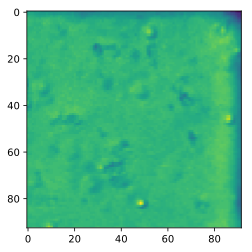

In [17]:
#separate subgrids into individual microwell images and save images, csv file, and html file
#also does some processing of the microwell images to calculate area of the cell/organoid within, you may or may not need this

from skimage import data, filters
import operator
from mpl_toolkits.axes_grid1 import make_axes_locatable
timecourse_length = 1 #0 indexed

#also saves csv and html files with values for each day
output_csv = '/Volumes/Jacqueline_Drive/cs231n/Data/Output/Stitched/Gem_low/well_summary.csv'
output_html = '/Volumes/Jacqueline_Drive/cs231n/Data/Output/Stitched/Gem_low/well_summary.html'
html_header(output_html)
with open(output_csv, "w") as out:
    header = 'well id' + ',' + 'day' + ',' + 'median pixel intensity' + ',' + 'hyst1 area' + ',' + 'hyst2 area' + "\n"
    out.write(header)   

#iterate through days
day = 14
#for day in range(timecourse_length):
#import csv and tif files you just saved above
reimport = pd.read_csv('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/Day{0}-1-20190507.csv'.format(day))
imagePath = '/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/Day{0}-1-20190507.tif'.format(day)
with skimage.external.tifffile.TiffFile(imagePath) as tif:
    data = tif.asarray()

#iterate through wells
K = 1000
#reimport originally
print("Length total: ", len(reimport))
for i in range(5000, 6000):
    #pull out well location from csv
    chamberInfo = reimport.iloc[i]
    #slice image to that well
    xslice = ast.literal_eval(chamberInfo.summaryImg_xslice)
    yslice = ast.literal_eval(chamberInfo.summaryImg_yslice)
    well = data[chamberInfo.stack_indexer][xslice[0]:xslice[1],yslice[0]:yslice[1]]
    pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/day14_samples/well{0:04d}_day{1:02d}_well.png'.format(i, day), well, cmap="gray")

    #use the square finder to find the inside of the well 
    squares = find_squares(well)
    squares = np.sort(np.array(squares))

    #find square with smallest perimeter and set that equal to inner mw_area
    perimeters = {}
    for x in range(len(squares)):
        perimeter = cv.arcLength(squares[x], True)
        perimeters[x] = perimeter
    if len(perimeters) == 0:
        print('perimeters not found')
    else:
        small_key = min(perimeters.items(), key=operator.itemgetter(1))[0]
        min_x = np.min(squares[small_key][:,0])
        max_x = np.max(squares[small_key][:,0])
        min_y = np.min(squares[small_key][:,1])
        max_y = np.max(squares[small_key][:,1])

        mw_area = well[min_x+5:max_x-5,min_y+5:max_y-5]
        pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/day14_samples/well{0:04d}_day{1:02d}_mw_area.png'.format(i, day), mw_area, cmap="gray")
        pl.imshow(mw_area)

        #normalize image by median pixel intensity
        filtermedian = np.abs(mw_area.astype(float) - np.median(mw_area))

        kernel =  cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))
        closing = cv.morphologyEx(filtermedian, cv.MORPH_CLOSE, kernel)
        hyst1 = skimage.filters.apply_hysteresis_threshold(closing, 15,10 )
        #pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/testing/well{0:04d}_day{1:02d}_hyst1.png'.format(i, day), hyst1.astype(float), cmap="gray")
        

        kernel =  cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
        opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)

        hyst2 = filters.apply_hysteresis_threshold(opening, 15,10 )
        #pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/testing/well{0:04d}_day{1:02d}_hyst2.png'.format(i, day), hyst2.astype(float), cmap="gray")
        
        with open(output_csv, "a") as output:
            line = str(i) + ',' + str(day) + ',' + str(np.median(mw_area)) + ',' + str(np.sum(hyst1)) + ',' + str(np.sum(hyst2)) + "\n"
            output.write(line)

        html_row(i,day,np.median(mw_area),np.sum(hyst1),np.sum(hyst2),output_html)


        print('well' + " " +  str(i) + " " + 'day' + " " + str(day))

html_footer(output_html)

In [3]:
#Try inputting whole img to find squares
img = '/Users/JacquelineYau/cnn/Data/Gem_low/day14_stitched.tif'
with skimage.external.tifffile.TiffFile(img) as tif:
    data = tif.asarray()
print(data.shape, data[0])
squares = find_squares(data)
squares = np.sort(np.array(squares))
print(len(squares))

(20160, 22848) [ 47  47  48 ... 120 120 121]
1


In [ ]:
print(len(squares))
for i in range(len(squares)):
    print(squares[i].shape)
    mins = np.argmin(squares[i], axis=0)
    maxs = np.argmax(squares[i], axis=0)
    print(squares[i])
    mw_area = data[squares[i][mins[0]][0]:squares[i][maxs[0]][0],squares[i][mins[1]][1]:squares[i][maxs[1]][1]]
    pl.imsave('/Users/JacquelineYau/cnn/Data/gem_low_day_14_adaptive/day14well%d.png' % (i + 1), mw_area, cmap="gray")
    #pl.imshow(mw_area)

3488
(4, 2)
[[12077 20073]
 [11970 20070]
 [11966 20159]
 [12077 20159]]
(4, 2)
[[12359 20070]
 [12357 20159]
 [12471 20159]
 [12467 20071]]
(4, 2)
[[12172 20068]
 [12168 20159]
 [12280 20159]
 [12274 20068]]
(4, 2)
[[11588 20070]
 [11586 20159]
 [11698 20159]
 [11692 20067]]
(4, 2)
[[11396 20072]
 [11396 20159]
 [11507 20159]
 [11504 20069]]
(4, 2)
[[13060 20068]
 [13056 20159]
 [13169 20159]
 [13164 20068]]
(4, 2)
[[11206 20071]
 [11205 20159]
 [11316 20159]
 [11312 20066]]
(4, 2)
[[11020 20066]
 [11015 20158]
 [11127 20159]
 [11123 20065]]
(4, 2)
[[10827 20069]
 [10825 20159]
 [10936 20159]
 [10934 20065]]
(4, 2)
[[10435 20060]
 [10427 20159]
 [10540 20159]
 [10540 20063]]
(4, 2)
[[10245 20056]
 [10238 20159]
 [10351 20157]
 [10345 20057]]
(4, 2)
[[ 9859 20057]
 [ 9856 20159]
 [ 9970 20159]
 [ 9966 20053]]
(4, 2)
[[ 9672 20050]
 [ 9667 20157]
 [ 9780 20159]
 [ 9776 20051]]
(4, 2)
[[11590 19872]
 [11589 19986]
 [11692 19987]
 [11696 19875]]
(4, 2)
[[12657 19872]
 [12551 19874]
 [1255

(4, 2)
[[12189 17570]
 [12190 17681]
 [12294 17684]
 [12297 17572]]
(4, 2)
[[12186 17562]
 [12298 17564]
 [12297 17688]
 [12185 17683]]
(4, 2)
[[ 8011 17516]
 [ 8015 17631]
 [ 8134 17628]
 [ 8127 17516]]
(4, 2)
[[ 8011 17505]
 [ 8139 17517]
 [ 8131 17641]
 [ 8006 17630]]
(4, 2)
[[ 3992 17480]
 [ 3997 17592]
 [ 4117 17587]
 [ 4115 17478]]
(4, 2)
[[ 3407 17480]
 [ 3410 17593]
 [ 3521 17588]
 [ 3516 17478]]
(4, 2)
[[ 4121 17474]
 [ 4119 17594]
 [ 3988 17592]
 [ 3990 17472]]
(4, 2)
[[ 3398 17479]
 [ 3521 17471]
 [ 3526 17594]
 [ 3409 17599]]
(4, 2)
[[14650 17415]
 [14644 17523]
 [14750 17534]
 [14756 17419]]
(4, 2)
[[14643 17411]
 [14763 17416]
 [14759 17534]
 [14639 17528]]
(4, 2)
[[13682 17398]
 [13679 17507]
 [13784 17513]
 [13790 17403]]
(4, 2)
[[13678 17392]
 [13796 17398]
 [13791 17515]
 [13670 17508]]
(4, 2)
[[11797 17372]
 [11794 17480]
 [11903 17484]
 [11904 17374]]
(4, 2)
[[11608 17369]
 [11602 17480]
 [11714 17480]
 [11711 17370]]
(4, 2)
[[11794 17366]
 [11908 17369]
 [11906 174

(4, 2)
[[ 1878 16280]
 [ 1802 16357]
 [ 1884 16438]
 [ 1962 16360]]
(4, 2)
[[ 1877 16271]
 [ 1970 16356]
 [ 1890 16444]
 [ 1797 16362]]
(4, 2)
[[12002 16199]
 [12000 16310]
 [12115 16316]
 [12123 16205]]
(4, 2)
[[11997 16195]
 [12125 16197]
 [12119 16322]
 [11994 16312]]
(4, 2)
[[11232 16189]
 [11231 16299]
 [11336 16302]
 [11341 16192]]
(4, 2)
[[11228 16183]
 [11347 16189]
 [11341 16305]
 [11227 16304]]
(4, 2)
[[10265 16177]
 [10263 16290]
 [10368 16291]
 [10366 16178]]
(4, 2)
[[10075 16174]
 [10071 16287]
 [10174 16292]
 [10180 16180]]
(4, 2)
[[ 9880 16175]
 [ 9878 16282]
 [ 9984 16291]
 [ 9988 16177]]
(4, 2)
[[10261 16171]
 [10374 16176]
 [10373 16295]
 [10257 16291]]
(4, 2)
[[10069 16169]
 [10185 16176]
 [10182 16294]
 [10063 16286]]
(4, 2)
[[ 9879 16167]
 [ 9992 16171]
 [ 9989 16297]
 [ 9877 16289]]
(4, 2)
[[ 9106 16162]
 [ 9106 16275]
 [ 9210 16278]
 [ 9209 16165]]
(4, 2)
[[ 9099 16159]
 [ 9215 16161]
 [ 9216 16282]
 [ 9100 16276]]
(4, 2)
[[ 8596 16155]
 [ 8592 16262]
 [ 8703 162

(4, 2)
[[11442 14877]
 [11440 14988]
 [11548 14989]
 [11549 14883]]
(4, 2)
[[11632 14874]
 [11750 14882]
 [11744 14998]
 [11626 14993]]
(4, 2)
[[12473 14867]
 [12558 14953]
 [12467 15036]
 [12389 14944]]
(4, 2)
[[11438 14872]
 [11556 14882]
 [11549 14995]
 [11432 14988]]
(4, 2)
[[11056 14871]
 [11054 14980]
 [11161 14984]
 [11160 14871]]
(4, 2)
[[11055 14863]
 [11167 14868]
 [11164 14989]
 [11048 14982]]
(4, 2)
[[10656 14865]
 [10654 14973]
 [10776 14977]
 [10774 14866]]
(4, 2)
[[10465 14860]
 [10459 14968]
 [10566 14976]
 [10570 14864]]
(4, 2)
[[10649 14864]
 [10779 14861]
 [10781 14979]
 [10654 14981]]
(4, 2)
[[10462 14854]
 [10575 14859]
 [10572 14979]
 [10455 14973]]
(4, 2)
[[ 9887 14852]
 [ 9886 14964]
 [ 9993 14963]
 [ 9994 14857]]
(4, 2)
[[ 9883 14846]
 [10003 14857]
 [ 9994 14973]
 [ 9884 14970]]
(4, 2)
[[ 8784 14840]
 [ 8785 14950]
 [ 8891 14954]
 [ 8892 14842]]
(4, 2)
[[ 8594 14836]
 [ 8593 14945]
 [ 8699 14951]
 [ 8702 14842]]
(4, 2)
[[ 8779 14836]
 [ 8895 14835]
 [ 8895 149

(4, 2)
[[14257 18945]
 [14367 18952]
 [14363 19060]
 [14256 19056]]
(4, 2)
[[14249 19140]
 [14255 19255]
 [14373 19256]
 [14369 19134]]
(4, 2)
[[ 8210 14249]
 [ 8206 14356]
 [ 8315 14364]
 [ 8317 14251]]
(4, 2)
[[14246 18947]
 [14256 19065]
 [14376 19055]
 [14365 18940]]
(4, 2)
[[ 8004 14248]
 [ 8004 14358]
 [ 8126 14358]
 [ 8124 14248]]
(4, 2)
[[ 7813 14245]
 [ 7810 14354]
 [ 7919 14358]
 [ 7920 14249]]
(4, 2)
[[ 8205 14244]
 [ 8328 14253]
 [ 8320 14369]
 [ 8203 14364]]
(4, 2)
[[ 7999 14243]
 [ 8128 14243]
 [ 8132 14362]
 [ 8002 14365]]
(4, 2)
[[ 7430 14239]
 [ 7428 14354]
 [ 7534 14353]
 [ 7535 14245]]
(4, 2)
[[ 7807 14240]
 [ 7925 14244]
 [ 7922 14364]
 [ 7804 14356]]
(4, 2)
[[ 7237 14236]
 [ 7233 14346]
 [ 7345 14349]
 [ 7342 14240]]
(4, 2)
[[ 7422 14237]
 [ 7541 14240]
 [ 7535 14361]
 [ 7423 14355]]
(4, 2)
[[ 6851 14233]
 [ 6851 14346]
 [ 6953 14350]
 [ 6960 14239]]
(4, 2)
[[ 6642 14234]
 [ 6642 14342]
 [ 6764 14344]
 [ 6761 14232]]
(4, 2)
[[ 7235 14228]
 [ 7350 14238]
 [ 7351 143

(4, 2)
[[12822 13732]
 [12821 13841]
 [12928 13845]
 [12930 13734]]
(4, 2)
[[12822 13723]
 [12936 13731]
 [12932 13851]
 [12815 13843]]
(4, 2)
[[12435 13725]
 [12432 13830]
 [12543 13836]
 [12546 13729]]
(4, 2)
[[12244 13720]
 [12239 13828]
 [12347 13833]
 [12351 13723]]
(4, 2)
[[12434 13716]
 [12553 13728]
 [12542 13844]
 [12426 13833]]
(4, 2)
[[12039 13718]
 [12035 13826]
 [12156 13827]
 [12154 13717]]
(4, 2)
[[12240 13714]
 [12356 13720]
 [12352 13838]
 [12235 13832]]
(4, 2)
[[12033 13715]
 [12157 13711]
 [12162 13831]
 [12035 13834]]
(4, 2)
[[11457 13707]
 [11455 13815]
 [11565 13817]
 [11566 13708]]
(4, 2)
[[11455 13700]
 [11571 13704]
 [11567 13825]
 [11447 13815]]
(4, 2)
[[10477 13689]
 [10473 13797]
 [10583 13800]
 [10586 13695]]
(4, 2)
[[10472 13685]
 [10588 13686]
 [10585 13807]
 [10469 13800]]
(4, 2)
[[ 9704 13676]
 [ 9703 13786]
 [ 9806 13791]
 [ 9811 13679]]
(4, 2)
[[ 9511 13674]
 [ 9509 13782]
 [ 9613 13788]
 [ 9618 13675]]
(4, 2)
[[ 9699 13671]
 [ 9814 13672]
 [ 9812 137

(4, 2)
[[13168 13552]
 [13273 13551]
 [13279 13658]
 [13169 13663]]
(4, 2)
[[13166 13343]
 [13275 13349]
 [13272 13468]
 [13163 13468]]
(4, 2)
[[13158 13552]
 [13168 13670]
 [13282 13664]
 [13278 13547]]
(4, 2)
[[13155 13157]
 [13149 13265]
 [13259 13269]
 [13160 13259]]
(4, 2)
[[13159 13339]
 [13159 13473]
 [13277 13473]
 [13274 13338]]
(4, 2)
[[13151 13153]
 [13162 13269]
 [13262 13276]
 [13143 13267]]
(4, 2)
[[11855 13133]
 [11854 13243]
 [11960 13245]
 [11963 13139]]
(4, 2)
[[11844 13134]
 [11962 13129]
 [11966 13248]
 [11849 13247]]
(4, 2)
[[11466 13127]
 [11463 13236]
 [11569 13240]
 [11573 13128]]
(4, 2)
[[11272 13124]
 [11272 13234]
 [11380 13234]
 [11382 13127]]
(4, 2)
[[11460 13123]
 [11577 13123]
 [11581 13237]
 [11461 13240]]
(4, 2)
[[11079 13121]
 [11077 13228]
 [11183 13233]
 [11189 13124]]
(4, 2)
[[11265 13121]
 [11381 13117]
 [11387 13237]
 [11267 13238]]
(4, 2)
[[11076 13114]
 [11195 13121]
 [11189 13236]
 [11074 13233]]
(4, 2)
[[ 9713 13088]
 [ 9709 13207]
 [ 9817 132

(4, 2)
[[11979 13767]
 [12106 13761]
 [12115 13865]
 [11989 13876]]
(4, 2)
[[11975 13762]
 [11979 13876]
 [12117 13874]
 [12110 13757]]
(4, 2)
[[11961 12851]
 [12075 12850]
 [12075 12956]
 [11968 12959]]
(4, 2)
[[11959 12657]
 [12069 12655]
 [12074 12759]
 [11962 12763]]
(4, 2)
[[11956 12848]
 [11961 12962]
 [12081 12958]
 [12075 12841]]
(4, 2)
[[11953 12654]
 [11960 12770]
 [12078 12765]
 [12070 12647]]
(4, 2)
[[11952 12063]
 [12063 12067]
 [12060 12182]
 [11952 12184]]
(4, 2)
[[11944 12062]
 [11946 12186]
 [12061 12189]
 [12066 12067]]
(4, 2)
[[10119 11913]
 [10110 12019]
 [10224 12025]
 [10225 11917]]
(4, 2)
[[10113 11910]
 [10231 11915]
 [10228 12030]
 [10108 12027]]
(4, 2)
[[ 9731 11908]
 [ 9727 12017]
 [ 9838 12017]
 [ 9840 11912]]
(4, 2)
[[ 9729 11902]
 [ 9847 11908]
 [ 9841 12024]
 [ 9721 12020]]
(4, 2)
[[ 4301 11863]
 [ 4195 11862]
 [ 4188 11974]
 [ 4295 11978]]
(4, 2)
[[ 4191 11859]
 [ 4308 11862]
 [ 4302 11979]
 [ 4187 11977]]
(4, 2)
[[ 2830 11856]
 [ 2826 11967]
 [ 2932 119

(4, 2)
[[ 9877 13601]
 [ 9885 13716]
 [ 9999 13716]
 [ 9996 13594]]
(4, 2)
[[ 9876 13392]
 [ 9875 13519]
 [ 9996 13519]
 [ 9995 13392]]
(4, 2)
[[ 9869 12689]
 [ 9977 12688]
 [ 9977 12798]
 [ 9867 12795]]
(4, 2)
[[ 9860 12691]
 [ 9867 12804]
 [ 9986 12796]
 [ 9977 12680]]
(4, 2)
[[ 9835 10939]
 [ 9943 10933]
 [ 9946 11046]
 [ 9836 11046]]
(4, 2)
[[ 9835 10727]
 [ 9944 10729]
 [ 9945 10850]
 [ 9836 10854]]
(4, 2)
[[ 9829 10936]
 [ 9833 11051]
 [ 9952 11048]
 [ 9947 10930]]
(4, 2)
[[ 9828 10537]
 [ 9940 10534]
 [ 9942 10642]
 [ 9836 10647]]
(4, 2)
[[ 9831 10723]
 [ 9829 10856]
 [ 9950 10855]
 [ 9950 10725]]
(4, 2)
[[ 9832 10337]
 [ 9939 10345]
 [ 9937 10450]
 [ 9829 10450]]
(4, 2)
[[ 9825 19973]
 [ 9937 19976]
 [ 9937 20082]
 [ 9826 20082]]
(4, 2)
[[ 9824 10532]
 [ 9826 10647]
 [ 9946 10648]
 [ 9944 10529]]
(4, 2)
[[ 9824 10147]
 [ 9933 10146]
 [ 9937 10252]
 [ 9823 10255]]
(4, 2)
[[ 9821 10339]
 [ 9825 10456]
 [ 9945 10451]
 [ 9942 10337]]
(4, 2)
[[ 9820 19969]
 [ 9823 20088]
 [ 9942 200

(4, 2)
[[ 9398 18218]
 [ 9405 18334]
 [ 9525 18330]
 [ 9516 18213]]
(4, 2)
[[7672 9397]
 [7788 9401]
 [7786 9520]
 [7666 9515]]
(4, 2)
[[6687 9397]
 [6685 9502]
 [6813 9503]
 [6813 9394]]
(4, 2)
[[6688 9390]
 [6819 9390]
 [6819 9507]
 [6688 9510]]
(4, 2)
[[5915 9388]
 [5914 9498]
 [6022 9500]
 [6027 9391]]
(4, 2)
[[5319 9384]
 [5319 9494]
 [5443 9493]
 [5441 9382]]
(4, 2)
[[5913 9381]
 [6031 9385]
 [6028 9503]
 [5908 9501]]
(4, 2)
[[5312 9383]
 [5445 9376]
 [5450 9495]
 [5314 9497]]
(4, 2)
[[4523 9375]
 [4415 9378]
 [4419 9491]
 [4525 9486]]
(4, 2)
[[3545 9376]
 [3434 9373]
 [3428 9481]
 [3539 9486]]
(4, 2)
[[2850 9375]
 [2851 9480]
 [2959 9482]
 [2962 9371]]
(4, 2)
[[3431 9367]
 [3549 9370]
 [3547 9487]
 [3426 9487]]
(4, 2)
[[2258 9367]
 [2256 9475]
 [2363 9480]
 [2369 9367]]
(4, 2)
[[2846 9368]
 [2967 9365]
 [2969 9482]
 [2845 9482]]
(4, 2)
[[2258 9359]
 [2374 9362]
 [2373 9480]
 [2249 9476]]
(4, 2)
[[ 9344 15551]
 [ 9450 15550]
 [ 9457 15657]
 [ 9348 15661]]
(4, 2)
[[ 9338 15359]
 [

(4, 2)
[[1490 8965]
 [1488 9081]
 [1597 9083]
 [1599 8966]]
(4, 2)
[[2068 8964]
 [2185 8966]
 [2180 9095]
 [2062 9088]]
(4, 2)
[[ 8960 16152]
 [ 9075 16149]
 [ 9084 16253]
 [ 8962 16257]]
(4, 2)
[[1486 8959]
 [1605 8963]
 [1603 9088]
 [1481 9082]]
(4, 2)
[[ 762 8959]
 [ 769 9079]
 [ 873 9078]
 [ 873 8956]]
(4, 2)
[[ 8955 16148]
 [ 8959 16264]
 [ 9088 16259]
 [ 9078 16144]]
(4, 2)
[[ 764 8949]
 [ 881 8954]
 [ 878 9083]
 [ 759 9076]]
(4, 2)
[[ 8941 15366]
 [ 9052 15365]
 [ 9055 15471]
 [ 8944 15472]]
(4, 2)
[[ 8935 15362]
 [ 8939 15476]
 [ 9059 15475]
 [ 9056 15360]]
(4, 2)
[[ 8935 15174]
 [ 9046 15171]
 [ 9050 15277]
 [ 8942 15282]]
(4, 2)
[[ 8929 15170]
 [ 8939 15287]
 [ 9057 15280]
 [ 9052 15167]]
(4, 2)
[[ 8914 14193]
 [ 9025 14191]
 [ 9028 14301]
 [ 8917 14302]]
(4, 2)
[[ 8908 14191]
 [ 8916 14309]
 [ 9035 14302]
 [ 9029 14186]]
(4, 2)
[[ 8900 13618]
 [ 9009 13611]
 [ 9014 13724]
 [ 8905 13722]]
(4, 2)
[[ 8897 13611]
 [ 8903 13729]
 [ 9023 13724]
 [ 9017 13610]]
(4, 2)
[[ 8869 11724

(4, 2)
[[ 8271 10554]
 [ 8379 10561]
 [ 8374 10668]
 [ 8271 10670]]
(4, 2)
[[ 8264 10961]
 [ 8272 11077]
 [ 8390 11070]
 [ 8383 10952]]
(4, 2)
[[ 8265 10366]
 [ 8376 10368]
 [ 8376 10471]
 [ 8269 10477]]
(4, 2)
[[ 8261 10556]
 [ 8266 10674]
 [ 8383 10670]
 [ 8380 10553]]
(4, 2)
[[ 8261 10172]
 [ 8367 10167]
 [ 8375 10276]
 [ 8261 10280]]
(4, 2)
[[ 8259 10362]
 [ 8263 10481]
 [ 8379 10478]
 [ 8376 10361]]
(4, 2)
[[ 8253 10172]
 [ 8260 10288]
 [ 8374 10287]
 [ 8375 10164]]
(4, 2)
[[8257 9785]
 [8365 9783]
 [8367 9894]
 [8260 9896]]
(4, 2)
[[8252 9595]
 [8366 9594]
 [8367 9697]
 [8257 9702]]
(4, 2)
[[8247 9786]
 [8257 9902]
 [8371 9899]
 [8370 9778]]
(4, 2)
[[8248 9590]
 [8251 9705]
 [8373 9700]
 [8368 9587]]
(4, 2)
[[8238 8288]
 [8283 8345]
 [8351 8393]
 [8244 8399]]
(4, 2)
[[7887 8234]
 [7880 8341]
 [7994 8346]
 [7994 8236]]
(4, 2)
[[8231 8286]
 [8238 8402]
 [8356 8398]
 [8279 8350]]
(4, 2)
[[7884 8229]
 [7998 8232]
 [7997 8351]
 [7879 8350]]
(4, 2)
[[7108 8229]
 [7106 8335]
 [7215 8341

(4, 2)
[[ 6755 19787]
 [ 6866 19782]
 [ 6873 19891]
 [ 6762 19893]]
(4, 2)
[[ 6755 10983]
 [ 6863 10980]
 [ 6866 11091]
 [ 6758 11093]]
(4, 2)
[[ 6756 19776]
 [ 6756 19896]
 [ 6874 19900]
 [ 6876 19782]]
(4, 2)
[[ 6748 10982]
 [ 6754 11097]
 [ 6872 11093]
 [ 6867 10976]]
(4, 2)
[[ 6745 10194]
 [ 6853 10190]
 [ 6860 10297]
 [ 6750 10304]]
(4, 2)
[[ 6742 10306]
 [ 6860 10307]
 [ 6863 10191]
 [ 6743 10189]]
(4, 2)
[[6732 8697]
 [6843 8694]
 [6843 8801]
 [6736 8806]]
(4, 2)
[[6729 8307]
 [6834 8302]
 [6841 8413]
 [6727 8412]]
(4, 2)
[[6730 8690]
 [6735 8811]
 [6852 8800]
 [6845 8687]]
(4, 2)
[[6726 8115]
 [6837 8110]
 [6838 8220]
 [6731 8224]]
(4, 2)
[[6725 8301]
 [6721 8414]
 [6840 8423]
 [6845 8304]]
(4, 2)
[[6721 8110]
 [6727 8229]
 [6842 8224]
 [6837 8103]]
(4, 2)
[[6724 7514]
 [6832 7515]
 [6830 7624]
 [6722 7620]]
(4, 2)
[[6725 7433]
 [6722 7321]
 [6829 7318]
 [6831 7429]]
(4, 2)
[[6715 7516]
 [6720 7628]
 [6840 7623]
 [6833 7506]]
(4, 2)
[[6718 6933]
 [6829 6933]
 [6830 7039]
 [6718

(4, 2)
[[ 5578 11579]
 [ 5689 11571]
 [ 5694 11678]
 [ 5582 11681]]
(4, 2)
[[ 5579 11185]
 [ 5686 11186]
 [ 5691 11292]
 [ 5578 11295]]
(4, 2)
[[ 5575 11573]
 [ 5576 11684]
 [ 5698 11684]
 [ 5696 11569]]
(4, 2)
[[ 5574 10801]
 [ 5680 10797]
 [ 5686 10906]
 [ 5576 10910]]
(4, 2)
[[ 5571 11187]
 [ 5572 11298]
 [ 5691 11301]
 [ 5690 11181]]
(4, 2)
[[ 5569 10797]
 [ 5571 10914]
 [ 5694 10905]
 [ 5684 10793]]
(4, 2)
[[ 5568 10312]
 [ 5573 10200]
 [ 5674 10200]
 [ 5677 10313]]
(4, 2)
[[5564 9819]
 [5671 9815]
 [5676 9924]
 [5567 9927]]
(4, 2)
[[5562 9629]
 [5670 9621]
 [5673 9733]
 [5566 9732]]
(4, 2)
[[ 5564 10316]
 [ 5685 10315]
 [ 5680 10197]
 [ 5563 10202]]
(4, 2)
[[5557 9533]
 [5566 9428]
 [5675 9434]
 [5670 9538]]
(4, 2)
[[5561 9813]
 [5566 9934]
 [5681 9928]
 [5675 9809]]
(4, 2)
[[5559 9621]
 [5565 9739]
 [5680 9733]
 [5678 9621]]
(4, 2)
[[5557 9426]
 [5560 9545]
 [5679 9539]
 [5674 9424]]
(4, 2)
[[5360 5531]
 [5361 5641]
 [5486 5641]
 [5486 5532]]
(4, 2)
[[5360 5526]
 [5490 5529]
 [5

(4, 2)
[[ 4595 11391]
 [ 4600 11506]
 [ 4719 11501]
 [ 4715 11385]]
(4, 2)
[[ 4594 11116]
 [ 4709 11121]
 [ 4717 11005]
 [ 4599 10998]]
(4, 2)
[[ 4590 10812]
 [ 4598 10927]
 [ 4714 10922]
 [ 4710 10805]]
(4, 2)
[[4593 9631]
 [4701 9636]
 [4698 9743]
 [4589 9741]]
(4, 2)
[[4589 9750]
 [4706 9743]
 [4705 9630]
 [4582 9634]]
(4, 2)
[[4583 8910]
 [4692 8906]
 [4694 9016]
 [4586 9018]]
(4, 2)
[[4578 8907]
 [4580 9021]
 [4702 9018]
 [4695 8901]]
(4, 2)
[[4565 6863]
 [4571 6758]
 [4678 6756]
 [4681 6868]]
(4, 2)
[[ 4565 18652]
 [ 4671 18647]
 [ 4677 18760]
 [ 4568 18759]]
(4, 2)
[[4564 6758]
 [4568 6874]
 [4688 6870]
 [4686 6756]]
(4, 2)
[[ 4559 18649]
 [ 4568 18769]
 [ 4684 18762]
 [ 4677 18643]]
(4, 2)
[[ 4557 18458]
 [ 4666 18455]
 [ 4671 18564]
 [ 4564 18570]]
(4, 2)
[[4554 4661]
 [4655 4661]
 [4665 4767]
 [4555 4769]]
(4, 2)
[[ 4551 18454]
 [ 4561 18576]
 [ 4680 18565]
 [ 4674 18455]]
(4, 2)
[[4181 4548]
 [4073 4556]
 [4074 4660]
 [4185 4663]]
(4, 2)
[[3876 4547]
 [3863 4657]
 [3977 4662

(4, 2)
[[ 4002 10609]
 [ 4124 10607]
 [ 4125 10716]
 [ 4003 10717]]
(4, 2)
[[ 4002 10413]
 [ 4122 10412]
 [ 4124 10523]
 [ 4002 10522]]
(4, 2)
[[ 3997 10130]
 [ 4002 10022]
 [ 4125 10031]
 [ 4124 10133]]
(4, 2)
[[ 4001 10601]
 [ 4002 10724]
 [ 4131 10719]
 [ 4129 10603]]
(4, 2)
[[3997 9831]
 [4117 9828]
 [4124 9935]
 [4002 9942]]
(4, 2)
[[ 3998 10408]
 [ 4000 10529]
 [ 4130 10525]
 [ 4128 10408]]
(4, 2)
[[ 3996 10138]
 [ 4123 10141]
 [ 4127 10022]
 [ 3997 10019]]
(4, 2)
[[3990 9830]
 [3995 9945]
 [4127 9942]
 [4123 9825]]
(4, 2)
[[3991 9018]
 [3992 8911]
 [4115 8912]
 [4114 9021]]
(4, 2)
[[3986 8524]
 [4112 8523]
 [4113 8631]
 [3990 8631]]
(4, 2)
[[ 3988 19071]
 [ 4106 19068]
 [ 4112 19178]
 [ 3989 19179]]
(4, 2)
[[3986 8328]
 [4106 8323]
 [4110 8438]
 [3990 8437]]
(4, 2)
[[3987 8907]
 [3988 9025]
 [4120 9025]
 [4114 8903]]
(4, 2)
[[3982 8520]
 [3992 8641]
 [4120 8633]
 [4114 8516]]
(4, 2)
[[3980 8326]
 [3991 8446]
 [4117 8441]
 [4115 8324]]
(4, 2)
[[ 3981 19067]
 [ 3990 19188]
 [ 4116

(4, 2)
[[ 3641 14369]
 [ 3764 14364]
 [ 3759 14249]
 [ 3637 14254]]
(4, 2)
[[ 3636 20056]
 [ 3748 20053]
 [ 3748 20177]
 [ 3639 20176]]
(4, 2)
[[ 3636 14061]
 [ 3642 14179]
 [ 3761 14172]
 [ 3753 14055]]
(4, 2)
[[ 3631 13381]
 [ 3637 13282]
 [ 3737 13286]
 [ 3738 13383]]
(4, 2)
[[ 3637 20045]
 [ 3635 20182]
 [ 3755 20181]
 [ 3753 20047]]
(4, 2)
[[ 3631 13489]
 [ 3741 13483]
 [ 3744 13593]
 [ 3634 13595]]
(4, 2)
[[ 3631 19861]
 [ 3738 19857]
 [ 3742 19967]
 [ 3634 19969]]
(4, 2)
[[ 3629 13481]
 [ 3626 13596]
 [ 3746 13600]
 [ 3748 13482]]
(4, 2)
[[ 3626 19855]
 [ 3630 19975]
 [ 3751 19968]
 [ 3742 19850]]
(4, 2)
[[ 3620 11900]
 [ 3619 11790]
 [ 3730 11788]
 [ 3729 11898]]
(4, 2)
[[ 3619 11014]
 [ 3725 11011]
 [ 3725 11124]
 [ 3615 11122]]
(4, 2)
[[ 3612 19476]
 [ 3722 19468]
 [ 3726 19581]
 [ 3618 19582]]
(4, 2)
[[ 3613 10717]
 [ 3614 10612]
 [ 3726 10611]
 [ 3725 10719]]
(4, 2)
[[ 3618 10414]
 [ 3723 10416]
 [ 3725 10524]
 [ 3617 10526]]
(4, 2)
[[ 3616 11785]
 [ 3613 11900]
 [ 3731 119

(4, 2)
[[ 3149 20868]
 [ 3262 20860]
 [ 3265 20972]
 [ 3157 20976]]
(4, 2)
[[ 3147 20858]
 [ 3153 20981]
 [ 3275 20972]
 [ 3265 20852]]
(4, 2)
[[ 3143 20672]
 [ 3254 20666]
 [ 3259 20774]
 [ 3149 20780]]
(4, 2)
[[ 3142 15053]
 [ 3250 15051]
 [ 3255 15159]
 [ 3143 15163]]
(4, 2)
[[ 3137 20667]
 [ 3144 20784]
 [ 3268 20776]
 [ 3261 20661]]
(4, 2)
[[ 3136 20477]
 [ 3246 20473]
 [ 3252 20580]
 [ 3138 20584]]
(4, 2)
[[ 3133 14865]
 [ 3244 14856]
 [ 3252 14964]
 [ 3140 14971]]
(4, 2)
[[ 3137 15048]
 [ 3141 15170]
 [ 3264 15159]
 [ 3255 15045]]
(4, 2)
[[ 3130 20473]
 [ 3139 20593]
 [ 3257 20586]
 [ 3249 20465]]
(4, 2)
[[ 3128 14860]
 [ 3139 14978]
 [ 3257 14969]
 [ 3249 14852]]
(4, 2)
[[ 3128 20284]
 [ 3239 20280]
 [ 3242 20389]
 [ 3136 20394]]
(4, 2)
[[ 3123 20278]
 [ 3130 20397]
 [ 3251 20390]
 [ 3246 20274]]
(4, 2)
[[ 3125 20072]
 [ 3235 20075]
 [ 3233 20195]
 [ 3126 20198]]
(4, 2)
[[ 3122 14075]
 [ 3233 14072]
 [ 3235 14180]
 [ 3127 14183]]
(4, 2)
[[ 3122 13880]
 [ 3232 13882]
 [ 3232 139

(4, 2)
[[2852 2910]
 [2911 2959]
 [2958 3023]
 [2849 3018]]
(4, 2)
[[2850 3685]
 [2852 3804]
 [2971 3802]
 [2968 3684]]
(4, 2)
[[2512 2846]
 [2506 2955]
 [2618 2960]
 [2619 2851]]
(4, 2)
[[ 2848 18314]
 [ 2853 18437]
 [ 2971 18431]
 [ 2963 18312]]
(4, 2)
[[2845 2908]
 [2850 3029]
 [2966 3025]
 [2911 2969]]
(4, 2)
[[1927 2843]
 [1923 2953]
 [2037 2953]
 [2037 2847]]
(4, 2)
[[ 2841 18129]
 [ 2950 18123]
 [ 2955 18234]
 [ 2850 18240]]
(4, 2)
[[2510 2840]
 [2627 2849]
 [2621 2967]
 [2499 2958]]
(4, 2)
[[1648 2843]
 [1538 2842]
 [1535 2951]
 [1647 2951]]
(4, 2)
[[1454 2845]
 [1330 2841]
 [1325 2948]
 [1448 2955]]
(4, 2)
[[ 2837 18123]
 [ 2845 18243]
 [ 2963 18234]
 [ 2954 18117]]
(4, 2)
[[1924 2838]
 [2047 2845]
 [2039 2962]
 [1919 2958]]
(4, 2)
[[ 810 2838]
 [ 808 2949]
 [ 917 2951]
 [ 918 2839]]
(4, 2)
[[1536 2835]
 [1656 2842]
 [1646 2962]
 [1532 2956]]
(4, 2)
[[1319 2844]
 [1456 2836]
 [1460 2955]
 [1329 2962]]
(4, 2)
[[ 2833 17936]
 [ 2943 17930]
 [ 2949 18038]
 [ 2842 18045]]
(4, 2)
[

(4, 2)
[[2465 4865]
 [2469 4979]
 [2593 4976]
 [2583 4858]]
(4, 2)
[[ 2463 18338]
 [ 2572 18331]
 [ 2576 18443]
 [ 2471 18449]]
(4, 2)
[[2463 3111]
 [2572 3106]
 [2576 3215]
 [2467 3220]]
(4, 2)
[[ 2457 18334]
 [ 2465 18453]
 [ 2586 18443]
 [ 2579 18327]]
(4, 2)
[[2125 2458]
 [2122 2570]
 [2234 2567]
 [2235 2464]]
(4, 2)
[[2459 3107]
 [2458 3221]
 [2583 3221]
 [2579 3104]]
(4, 2)
[[2123 2451]
 [2244 2462]
 [2233 2579]
 [2119 2574]]
(4, 2)
[[1247 2455]
 [1139 2452]
 [1132 2561]
 [1246 2563]]
(4, 2)
[[ 816 2449]
 [ 811 2563]
 [ 920 2564]
 [ 922 2454]]
(4, 2)
[[ 2449 17949]
 [ 2560 17947]
 [ 2561 18054]
 [ 2452 18058]]
(4, 2)
[[1138 2444]
 [1256 2454]
 [1250 2571]
 [1129 2565]]
(4, 2)
[[ 922 2444]
 [ 930 2566]
 [ 810 2570]
 [ 807 2447]]
(4, 2)
[[ 341 2451]
 [ 231 2447]
 [ 225 2554]
 [ 342 2558]]
(4, 2)
[[ 2444 17943]
 [ 2452 18066]
 [ 2570 18056]
 [ 2563 17940]]
(4, 2)
[[ 220 2449]
 [ 342 2442]
 [ 347 2564]
 [ 222 2561]]
(4, 2)
[[ 2441 17754]
 [ 2552 17752]
 [ 2554 17860]
 [ 2441 17859]]


(4, 2)
[[ 2128 13707]
 [ 2134 13823]
 [ 2254 13819]
 [ 2246 13698]]
(4, 2)
[[ 2127 10040]
 [ 2238 10041]
 [ 2237 10148]
 [ 2130 10151]]
(4, 2)
[[ 2128 11335]
 [ 2128 11225]
 [ 2234 11222]
 [ 2235 11334]]
(4, 2)
[[2129 9843]
 [2238 9849]
 [2235 9956]
 [2124 9950]]
(4, 2)
[[ 2126 11918]
 [ 2126 11807]
 [ 2233 11804]
 [ 2235 11915]]
(4, 2)
[[ 2125 11526]
 [ 2128 11417]
 [ 2239 11422]
 [ 2234 11529]]
(4, 2)
[[2124 9653]
 [2231 9648]
 [2235 9760]
 [2124 9757]]
(4, 2)
[[ 2120 19535]
 [ 2235 19530]
 [ 2236 19637]
 [ 2126 19642]]
(4, 2)
[[2121 9247]
 [2227 9241]
 [2233 9353]
 [2122 9354]]
(4, 2)
[[ 2118 11527]
 [ 2237 11534]
 [ 2238 11412]
 [ 2125 11413]]
(4, 2)
[[ 2121 11224]
 [ 2125 11339]
 [ 2243 11334]
 [ 2236 11215]]
(4, 2)
[[ 2118 10041]
 [ 2125 10156]
 [ 2242 10152]
 [ 2240 10034]]
(4, 2)
[[ 2127 11799]
 [ 2120 11919]
 [ 2240 11920]
 [ 2241 11803]]
(4, 2)
[[2124 8917]
 [2231 8923]
 [2230 9031]
 [2122 9030]]
(4, 2)
[[2117 9650]
 [2123 9765]
 [2241 9762]
 [2235 9642]]
(4, 2)
[[2118 9241]


(4, 2)
[[1881 6090]
 [2001 6092]
 [2003 5976]
 [1882 5972]]
(4, 2)
[[1878 5194]
 [1988 5188]
 [1994 5297]
 [1881 5298]]
(4, 2)
[[1878 5780]
 [1886 5902]
 [2001 5897]
 [1999 5780]]
(4, 2)
[[1876 4870]
 [1985 4865]
 [1991 4973]
 [1881 4977]]
(4, 2)
[[1873 5592]
 [1883 5707]
 [1999 5705]
 [1996 5585]]
(4, 2)
[[1874 5187]
 [1882 5308]
 [2000 5302]
 [1990 5180]]
(4, 2)
[[1876 4480]
 [1984 4479]
 [1989 4586]
 [1879 4590]]
(4, 2)
[[1875 4287]
 [1984 4285]
 [1986 4397]
 [1879 4398]]
(4, 2)
[[1873 3889]
 [1982 3883]
 [1988 3994]
 [1882 4001]]
(4, 2)
[[1877 3691]
 [1985 3696]
 [1983 3803]
 [1871 3800]]
(4, 2)
[[1878 3495]
 [1985 3502]
 [1983 3609]
 [1872 3608]]
(4, 2)
[[ 1871 18361]
 [ 1979 18352]
 [ 1983 18467]
 [ 1877 18470]]
(4, 2)
[[1873 4863]
 [1880 4986]
 [1997 4978]
 [1989 4860]]
(4, 2)
[[1868 4480]
 [1876 4598]
 [1993 4593]
 [1990 4475]]
(4, 2)
[[1869 3883]
 [1875 4006]
 [1993 3999]
 [1986 3878]]
(4, 2)
[[1868 3495]
 [1870 3617]
 [1993 3608]
 [1988 3494]]
(4, 2)
[[ 1869 18351]
 [ 1875 18

(4, 2)
[[ 1656 17785]
 [ 1763 17776]
 [ 1768 17891]
 [ 1662 17894]]
(4, 2)
[[ 427 1654]
 [ 550 1663]
 [ 541 1783]
 [ 421 1773]]
(4, 2)
[[ 230 1655]
 [ 349 1655]
 [ 353 1775]
 [ 235 1780]]
(4, 2)
[[ 1648 17783]
 [ 1659 17900]
 [ 1780 17889]
 [ 1768 17769]]
(4, 2)
[[ 1648 17590]
 [ 1756 17582]
 [ 1763 17694]
 [ 1655 17701]]
(4, 2)
[[ 1643 17584]
 [ 1649 17704]
 [ 1770 17698]
 [ 1762 17577]]
(4, 2)
[[ 1640 17384]
 [ 1749 17376]
 [ 1757 17496]
 [ 1645 17503]]
(4, 2)
[[ 1639 17374]
 [ 1639 17506]
 [ 1762 17503]
 [ 1759 17377]]
(4, 2)
[[ 1598 16480]
 [ 1709 16468]
 [ 1719 16576]
 [ 1608 16584]]
(4, 2)
[[ 1599 16467]
 [ 1606 16590]
 [ 1727 16579]
 [ 1715 16463]]
(4, 2)
[[ 1595 16280]
 [ 1706 16277]
 [ 1708 16386]
 [ 1596 16385]]
(4, 2)
[[ 1589 16276]
 [ 1593 16391]
 [ 1719 16385]
 [ 1712 16272]]
(4, 2)
[[ 1593 16067]
 [ 1703 16071]
 [ 1702 16191]
 [ 1591 16192]]
(4, 2)
[[ 1583 21119]
 [ 1697 21113]
 [ 1700 21225]
 [ 1589 21227]]
(4, 2)
[[ 1582 15875]
 [ 1694 15870]
 [ 1697 15979]
 [ 1586 1598

(4, 2)
[[1315 6768]
 [1420 6766]
 [1425 6878]
 [1316 6879]]
(4, 2)
[[1309 6960]
 [1318 7084]
 [1435 7074]
 [1428 6956]]
(4, 2)
[[ 1311 18972]
 [ 1311 19092]
 [ 1436 19087]
 [ 1425 18964]]
(4, 2)
[[1309 6765]
 [1316 6887]
 [1434 6879]
 [1426 6762]]
(4, 2)
[[1313 6169]
 [1419 6174]
 [1417 6284]
 [1306 6278]]
(4, 2)
[[ 1306 18771]
 [ 1416 18767]
 [ 1420 18892]
 [ 1310 18892]]
(4, 2)
[[1309 5977]
 [1416 5979]
 [1415 6091]
 [1307 6089]]
(4, 2)
[[1305 5785]
 [1412 5785]
 [1419 5892]
 [1309 5897]]
(4, 2)
[[ 1298 18768]
 [ 1307 18899]
 [ 1430 18891]
 [ 1418 18758]]
(4, 2)
[[1299 5191]
 [1408 5189]
 [1410 5301]
 [1298 5298]]
(4, 2)
[[1295 5784]
 [1307 5906]
 [1422 5899]
 [1421 5783]]
(4, 2)
[[1292 5190]
 [1299 5309]
 [1418 5303]
 [1413 5185]]
(4, 2)
[[1291 3891]
 [1397 3882]
 [1407 3994]
 [1294 3998]]
(4, 2)
[[1290 3697]
 [1402 3694]
 [1401 3806]
 [1294 3804]]
(4, 2)
[[1292 4097]
 [1401 4094]
 [1406 4203]
 [1293 4204]]
(4, 2)
[[1293 3306]
 [1402 3308]
 [1399 3418]
 [1290 3414]]
(4, 2)
[[1292 31

(4, 2)
[[  981 15500]
 [  984 15618]
 [ 1115 15609]
 [ 1107 15492]]
(4, 2)
[[  976 15304]
 [  982 15426]
 [ 1103 15418]
 [ 1102 15298]]
(4, 2)
[[  978 15111]
 [ 1091 15106]
 [ 1093 15220]
 [  980 15225]]
(4, 2)
[[  976 20745]
 [  981 20866]
 [ 1115 20854]
 [ 1101 20735]]
(4, 2)
[[  972 20559]
 [ 1091 20550]
 [ 1095 20664]
 [  981 20669]]
(4, 2)
[[  969 14921]
 [ 1088 14912]
 [ 1090 15024]
 [  974 15027]]
(4, 2)
[[  968 15112]
 [  973 15227]
 [ 1103 15221]
 [ 1095 15099]]
(4, 2)
[[  968 14912]
 [  973 15034]
 [ 1098 15027]
 [ 1092 14906]]
(4, 2)
[[  961 14317]
 [ 1078 14311]
 [ 1080 14423]
 [  963 14428]]
(4, 2)
[[  954 14315]
 [  962 14435]
 [ 1089 14425]
 [ 1080 14304]]
(4, 2)
[[  950 13931]
 [ 1072 13922]
 [ 1076 14029]
 [  960 14038]]
(4, 2)
[[  952 13730]
 [ 1069 13725]
 [ 1071 13835]
 [  953 13839]]
(4, 2)
[[  949 13922]
 [  955 14043]
 [ 1079 14037]
 [ 1077 13916]]
(4, 2)
[[  952 13531]
 [ 1064 13528]
 [ 1067 13641]
 [  952 13645]]
(4, 2)
[[  946 10437]
 [ 1065 10434]
 [ 1066 105

(4, 2)
[[ 707 5399]
 [ 712 5523]
 [ 830 5517]
 [ 825 5398]]
(4, 2)
[[ 707 4873]
 [ 815 4871]
 [ 821 4978]
 [ 707 4982]]
(4, 2)
[[ 702 4784]
 [ 706 4677]
 [ 815 4678]
 [ 817 4788]]
(4, 2)
[[ 707 5189]
 [ 709 5312]
 [ 829 5308]
 [ 825 5190]]
(4, 2)
[[ 703 4487]
 [ 813 4485]
 [ 818 4592]
 [ 704 4595]]
(4, 2)
[[ 699 4873]
 [ 706 4991]
 [ 827 4983]
 [ 824 4869]]
(4, 2)
[[ 702 4207]
 [ 704 4097]
 [ 813 4099]
 [ 813 4209]]
(4, 2)
[[ 701 4000]
 [ 704 3890]
 [ 812 3892]
 [ 812 4003]]
(4, 2)
[[ 703 4401]
 [ 705 4290]
 [ 809 4288]
 [ 815 4401]]
(4, 2)
[[ 697 3703]
 [ 807 3695]
 [ 810 3811]
 [ 700 3807]]
(4, 2)
[[ 699 4676]
 [ 705 4796]
 [ 826 4789]
 [ 818 4671]]
(4, 2)
[[ 697 4486]
 [ 705 4605]
 [ 824 4597]
 [ 816 4478]]
(4, 2)
[[ 696 3224]
 [ 700 3118]
 [ 809 3116]
 [ 813 3227]]
(4, 2)
[[ 702 2922]
 [ 807 2923]
 [ 809 3036]
 [ 697 3030]]
(4, 2)
[[ 699 2524]
 [ 807 2522]
 [ 813 2630]
 [ 699 2633]]
(4, 2)
[[ 705 4282]
 [ 700 4408]
 [ 818 4409]
 [ 821 4289]]
(4, 2)
[[ 700 4215]
 [ 820 4214]
 [ 814 

In [5]:

squares = find_squares(data)
squares = np.sort(np.array(squares))
print(len(squares))

3488
